# 训练 SRCNN

加载模型：

In [1]:
from set_env import temp_dir
from utils.srcnn import SRCNN
net = SRCNN(upscale_factor=4,)
net

项目根目录：/media/pc/data/lxw/ai/torch-book


SRCNN(
  (img_upsampler): Upsample(scale_factor=4.0, mode='bicubic')
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
)

加载训练数据：

In [2]:
from pathlib import Path
import io
from PIL import Image
from torchvision.transforms import v2
from dataclasses import dataclass
from typing import Callable
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import tv_tensors
from torch_book.datasets.cv.div2k import PairedDIV2K
from torch_book.data.cv.grid import (
    PairedGrid, GridConfig, PairedRandomCrop,
    FlattenPairedGrid,
)
from torch_book.data.cv.grid import Grid

class GridLoader(DataLoader):
    def __init__(self, dataset, *args, **kwargs):
        super().__init__(dataset, batch_size=1, *args, **kwargs)

    def __iter__(self):
        # 自定义迭代逻辑
        for lr, hr in super().__iter__():
            lr = lr[0].as_subclass(Grid)
            hr = hr[0].as_subclass(Grid)
            yield lr, hr

@dataclass
class PairedDataset(PairedDIV2K, Dataset):
    transform: Callable | None = None

    def __getitem__(self, index: int) -> list[tv_tensors.Image, tv_tensors.Image]:
        """加载(LR, HR)图片对
        Args:
            index: 图片的索引
        Returns:
            buffer: 图片的二进制内容
        """
        with Image.open(io.BytesIO(self.lr_dataset[index])) as im:
            lr = tv_tensors.Image(im)
        
        with Image.open(io.BytesIO(self.hr_dataset[index])) as im:
            hr = tv_tensors.Image(im)
        if self.transform is not None:
            lr, hr = self.transform(lr, hr)
        return lr, hr

def create_dataset(root, scale, transform):
    root = Path(root)
    # 将训练集和验证集合并
    _trainset = PairedDataset(
        scale,
        root/"DIV2K_train_HR.zip",
        root/f"DIV2K_train_LR_bicubic_X{scale}.zip",
        transform=transform
    )
    _valset = PairedDataset(
        scale,
        root/"DIV2K_valid_HR.zip",
        root/f"DIV2K_valid_LR_bicubic_X{scale}.zip",
        transform=transform
    )
    return _trainset + _valset

scale = 4 # 放大倍数, 2, 3, 4
# 加载图片对
config = GridConfig(
    crop_size = 480, # HR 的裁剪尺寸，这个尺寸通常是预先设定的
    step = 240, # 指在 HR 图像进行某种处理时，每次移动或采样的步长
    thresh_size = 0, # HR 图像处理中，用于判断或筛选某些特征或对象的尺寸阈值
)
transform = v2.Compose([
    PairedGrid(scale, config),
    PairedRandomCrop(scale=scale, gt_patch_size=128),
    # FlattenPairedGrid(),
])
data_dir = "/media/pc/data/lxw/data/SR/DIV2K"
data_dir = Path(data_dir)
dataset = create_dataset(data_dir, scale, transform)
# 打乱数据
loader = GridLoader(dataset, shuffle=True)

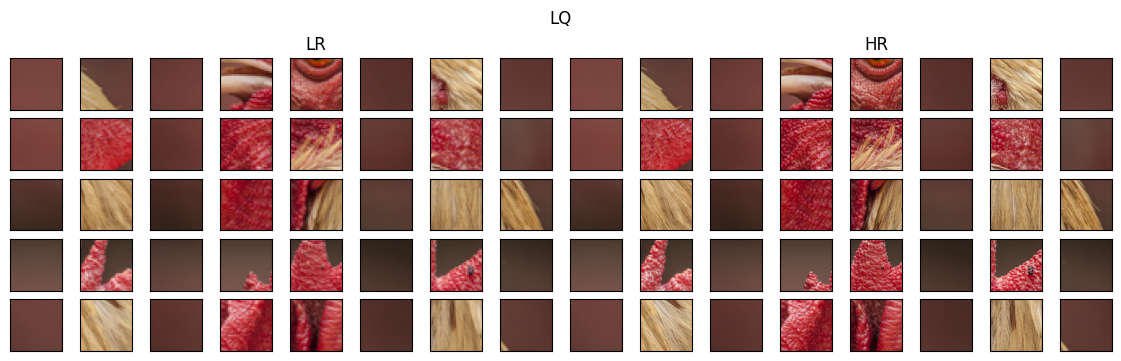

In [3]:
import torch
from torch_book.data.cv.plot import CompareGridFrame
import matplotlib.pyplot as plt
lr, hr = next(iter(loader))
with torch.no_grad():
    # 打乱图像块
    indexes = lr.randmeshgrid()
    lr = lr.shuffle(indexes)
    hr = hr.shuffle(indexes)
    canvas = CompareGridFrame(lr.height, lr.width, 0.7)
    left_axes, right_axes = canvas(lr.flatten().permute(0, 2, 3, 1), hr.flatten().permute(0, 2, 3, 1))
    left_axes[4].set_title("LR")
    right_axes[4].set_title("HR")
    canvas.figure.suptitle("LQ")
    plt.close()
canvas.figure

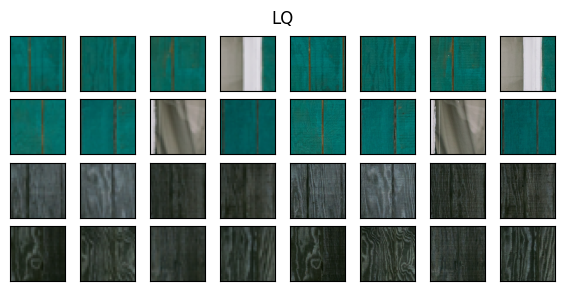

In [4]:
import torch
from torch_book.data.cv.plot import CompareGridFrame
import matplotlib.pyplot as plt

batch_size = 16
lr, hr = next(iter(loader))
with torch.no_grad():
    # 打乱图像块
    indexes = lr.randmeshgrid()
    lr = lr.shuffle(indexes)
    hr = hr.shuffle(indexes)
    # 批处理
    batch_lr = DataLoader(lr.flatten(), shuffle=False, batch_size=batch_size)
    batch_hr = DataLoader(hr.flatten(), shuffle=False, batch_size=batch_size)
    canvas = CompareGridFrame(4, batch_size//4, 0.7)
    left_axes, right_axes = canvas(next(iter(batch_lr)).permute(0, 2, 3, 1), next(iter(batch_hr)).permute(0, 2, 3, 1))
    canvas.figure.suptitle("LQ")
    plt.close()
canvas.figure